In [7]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.client import device_lib
from matplotlib import font_manager, rc, dates
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [8]:
print(tf.__version__)
print(device_lib.list_local_devices())

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9437955579978904665
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1480530889395974631
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [9]:
def reward_co2(co2):
    reward = np.exp(-((co2-900)**2)/(2*350**2))
    return reward

* 학습용 데이터셋 준비(솜사탕)

In [10]:
## 불러오기 ##
path = os.getcwd()
site_list = sorted(glob(os.path.join(path,"data","sensing_data","*")))
site_list = list(map(os.path.basename,site_list))
print(path)
print(site_list)
site = "솜사탕"
time_mean = "5T"
csv_by_site_det = []


structure = sorted(glob(os.path.join(path,"data","sensing_data",site,'*')))
structure = list(map(os.path.basename,structure))
for j in structure:
        temp_data = dd.read_csv(os.path.join(path,"data","sensing_data",site,j),encoding='cp949').compute()
        temp_data['T/D'] = pd.to_datetime(temp_data['T/D'])
       
        temp_data.set_index('T/D',inplace=True)
        temp_data = temp_data.resample(time_mean,).mean()
        temp_data['site_details'] = j
        csv_by_site_det.append(temp_data)

data = pd.concat(csv_by_site_det)
data.columns = ['index','temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']
data = data[['temp','hum','pm1','pm2.5','pm4','pm10','co2','tvoc','site_details']]
## 라벨링 ##

data['vent'] = 0
data['people'] = 0

data.loc[data.between_time('12:00:00', '18:00:00',include_end=False).index,['vent']] = 1
data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['people']] = 1

#0부터 월요일
data.loc[data[data.index.dayofweek == 5].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 5].index,['people']] = 0

data.loc[data[data.index.dayofweek == 6].index,['vent']] = 0
data.loc[data[data.index.dayofweek == 6].index,['people']] = 0



c:\Users\Go\OneDrive - UOS\allrepos\multi_agent_awac
['남부', '동화나라', '소리엘', '솜사탕', '예나']


C:\Users\Go\AppData\Local\Temp\ipykernel_15920\3622817103.py:31: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('12:00:00', '18:00:00',include_end=False).index,['vent']] = 1
C:\Users\Go\AppData\Local\Temp\ipykernel_15920\3622817103.py:32: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  data.loc[data.between_time('9:00:00', '16:00:00',include_end=False).index,['people']] = 1


In [11]:
room_list = ['솜사탕_거실.csv', '솜사탕_방1.csv','솜사탕_방2.csv','솜사탕_방3.csv','솜사탕_방4.csv','솜사탕_부엌.csv',]
data_by_room = {}
data_co2 = data.loc[:,['co2','site_details','vent','people']]

for i in room_list:
    room_name = i
    dataset = data_co2.loc[data_co2.site_details == room_name,:][['co2','vent','people']]

    dataset.loc[:,'co2_t+1'] = dataset.loc[:,'co2'].shift(-1)
    dataset.loc[:,'people_t+1'] = dataset.loc[:,'people'].shift(-1)
    dataset.loc[:,'reward'] = dataset.loc[:,'co2_t+1'].map(lambda x : reward_co2(x))
    dataset.loc[:,'done'] = False
    dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
    dataset = dataset.iloc[:-1,:]
    #데이터셋 추가
    data_by_room[i] = dataset.loc[:,:]



C:\Users\Go\AppData\Local\Temp\ipykernel_15920\3984230095.py:13: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
C:\Users\Go\AppData\Local\Temp\ipykernel_15920\3984230095.py:13: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
C:\Users\Go\AppData\Local\Temp\ipykernel_15920\3984230095.py:13: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).index,['done']] = True
C:\Users\Go\AppData\Local\Temp\ipykernel_15920\3984230095.py:13: FutureWarning: `include_start` and `include_end` are deprecated in favour of `inclusive`.
  dataset.loc[dataset.between_time('00:00:00', '00:05:00',include_end=False).ind

In [12]:
data_by_room[room_list[1]]

,co2,vent,people,co2_t+1,people_t+1,reward,done
T/D,,,,,,,
2021-12-29 17:15:00,950.867765,1,0,991.816033,0.0,0.966176,False
2021-12-29 17:20:00,991.816033,1,0,1035.277933,0.0,0.928027,False
2021-12-29 17:25:00,1035.277933,1,0,1070.793267,0.0,0.887752,False
2021-12-29 17:30:00,1070.793267,1,0,1071.176833,0.0,0.887277,False
2021-12-29 17:35:00,1071.176833,1,0,1067.187833,0.0,0.892179,False
...,...,...,...,...,...,...,...
2022-03-10 16:30:00,1376.824600,1,0,1279.189433,0.0,0.556062,False
2022-03-10 16:35:00,1279.189433,1,0,1282.804833,0.0,0.549844,False
2022-03-10 16:40:00,1282.804833,1,0,1251.916100,0.0,0.603210,False


* 데이터 시계열 플롯

CPU times: total: 1.02 s
Wall time: 1.06 s


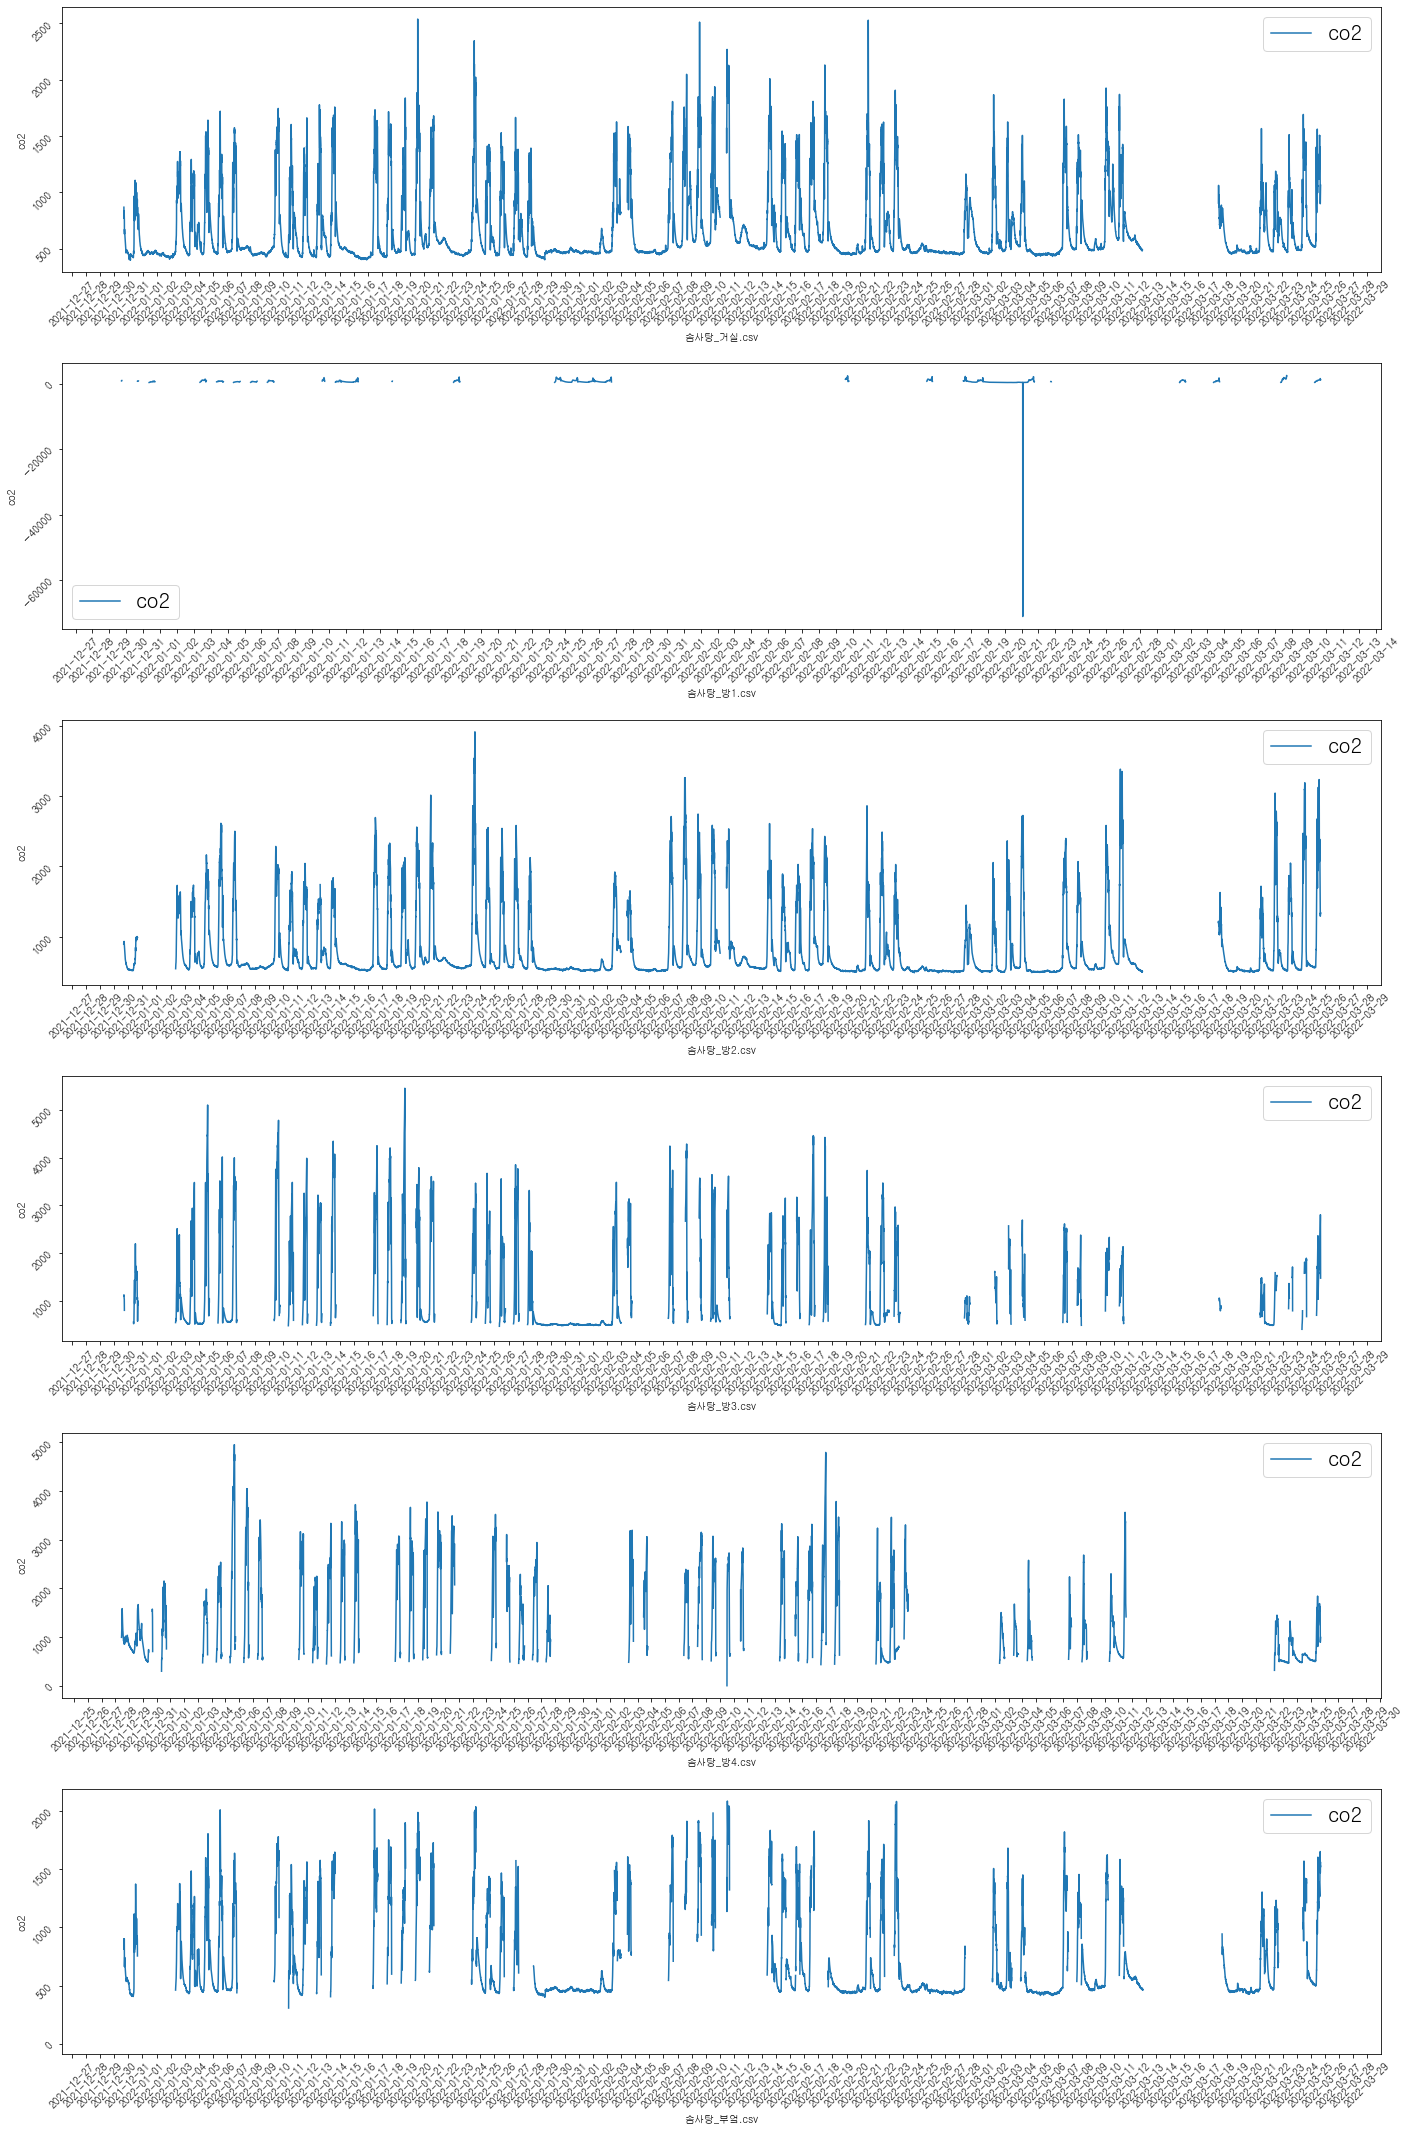

In [13]:
%%time
fig, axes = plt.subplots(len(room_list),1, figsize=(20,30))
# mean_by_date.loc[:,val].plot()
plt.rc('font', size=20)        # 기본 폰트 크기
# plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=20)  # 범례 폰트 크기
plt.rc('figure', titlesize=20)

for i, val in enumerate(room_list):
    p_data = data_by_room[val]

    axes[i].plot(p_data.loc[:,'co2'], label = 'co2')
    axes[i].set_ylabel('co2')
    axes[i].legend()
    axes[i].set_xlabel(val)
    axes[i].tick_params(labelrotation=45)
    axes[i].xaxis.set_major_locator(dates.DayLocator())
plt.tight_layout()

* 학습데이터 제작(쓸만한 데이터가 거실, 방2 밖에 없음), 방 4개 가정하고 거실,거실,방2,방2 데이터 사용
* ['2022-01-04':'2022-01-27'] 데이터 사용

In [173]:
# dense model 만드는 함수
def make_dense_model(hidden_structure,input_shape,act_function,output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    for i, val in enumerate(hidden_structure):
        n_percep = val 
        if i == 0:
            x = keras.layers.Dense(n_percep, activation= act_function)(inputs)

        elif  i != 0 and i != len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep, activation= act_function)(x)

        elif  i == len(hidden_structure)-1:
            x = keras.layers.Dense(n_percep,activation= act_function)(x)
    x = keras.layers.Dense(output_shape)(x)

    dense_model = tf.keras.Model(inputs=inputs, outputs=x)
    return dense_model

# multi_agent structure 만드는 함수
def build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape):
    actor_list = []
    critic_qnet_list = []
    critic_qnet_target_list = []
    for i in range(agent_num):
        actor_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
        critic_qnet_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
        critic_qnet_target_list.append(make_dense_model(hidden_structure,input_shape,act_function,output_shape))
    return actor_list, critic_qnet_list, critic_qnet_target_list


def get_action(actor,state, num_samples: int = 3):
    logit_sam = actor(state)
    m = tfp.distributions.Categorical(logits = logit_sam)
    return tf.reshape(m.sample(num_samples),[-1,num_samples])

def get_mean_qsa(qs,sampled_as):
    mean_q = tf.concat([tf.reshape(tf.gather(qs[i],sampled_as[i], axis=0),[1,-1]) for i in range(len(qs))],axis=0)
    mean_q = tf.math.reduce_mean(mean_q,axis=1,keepdims=True)
    return mean_q

## 방 4개, 수렴안됨

In [256]:
room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv', '솜사탕_거실.csv', '솜사탕_방2.csv']
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv']

s = []
ns = []
a_list = []
r_list = []

start_date = '2022-01-04'
end_date = '2022-01-27'
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    s.append(tf.convert_to_tensor(temp_data.values[:,[0,2],],dtype=tf.float32))
    ns.append(tf.convert_to_tensor(temp_data.values[:,[3,4],],dtype=tf.float32))
    a_list.append(tf.convert_to_tensor(temp_data.values[:,[1],],dtype=tf.int64))
    r_list.append(tf.convert_to_tensor(temp_data.values[:,[5],],dtype=tf.float32))

s = tf.concat(s,axis=1)
ns = tf.concat(ns,axis=1)


s_dataset = tf.data.Dataset.from_tensor_slices(s)
ns_dataset = tf.data.Dataset.from_tensor_slices(ns)

a1_dataset = tf.data.Dataset.from_tensor_slices(a_list[0])
a2_dataset = tf.data.Dataset.from_tensor_slices(a_list[1])
a3_dataset = tf.data.Dataset.from_tensor_slices(a_list[2])
a4_dataset = tf.data.Dataset.from_tensor_slices(a_list[3])

r1_dataset = tf.data.Dataset.from_tensor_slices(r_list[0])
r2_dataset = tf.data.Dataset.from_tensor_slices(r_list[1])
r3_dataset = tf.data.Dataset.from_tensor_slices(r_list[2])
r4_dataset = tf.data.Dataset.from_tensor_slices(r_list[3])

done_dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(data_by_room[i].loc[start_date:end_date].values[:,[6]],dtype=tf.float32))

train_dataset = tf.data.Dataset.zip((s_dataset, ns_dataset, ((a1_dataset,r1_dataset),(a2_dataset,r2_dataset),(a3_dataset,r3_dataset),(a4_dataset,r4_dataset),),done_dataset))
train_dataset.element_spec


(TensorSpec(shape=(8,), dtype=tf.float32, name=None),
 TensorSpec(shape=(8,), dtype=tf.float32, name=None),
 ((TensorSpec(shape=(1,), dtype=tf.int64, name=None),
   TensorSpec(shape=(1,), dtype=tf.float32, name=None)),
  (TensorSpec(shape=(1,), dtype=tf.int64, name=None),
   TensorSpec(shape=(1,), dtype=tf.float32, name=None)),
  (TensorSpec(shape=(1,), dtype=tf.int64, name=None),
   TensorSpec(shape=(1,), dtype=tf.float32, name=None)),
  (TensorSpec(shape=(1,), dtype=tf.int64, name=None),
   TensorSpec(shape=(1,), dtype=tf.float32, name=None))),
 TensorSpec(shape=(1,), dtype=tf.float32, name=None))

In [269]:
#################set params!################
# params of multi_AWAC
agent_num = 4
state_len = 2
hidden_structure= [64, 128, 256, 512,512,512, 256, 128, 64]
input_shape= state_len*agent_num
output_shape= 2
act_function= 'relu'
lam = 0.3
optimizer= keras.optimizers.Adam(learning_rate=3 * 1e-5)
gamma= 0.9
tau = 0.1
num_action_samples = 8
loss_fun = tf.keras.losses.MeanSquaredError()

# 배치관련
batch_size = 32
buffer_len = len(train_dataset)
n_train = 100
############################################
# 초기 모델 생성
actor_list, critic_qnet_list, critic_qnet_target_list = build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape)


#배치셋 생성
batched_dataset = train_dataset.shuffle(buffer_size=buffer_len).batch(batch_size, drop_remainder=True)

# 트레인 루프
for batch in batched_dataset.take(n_train):
    # print(batch[3])

    with tf.GradientTape() as t:
        loss_list =[]
        for j in range(agent_num):
            ##데이터 
            s = batch[0]
            ns = batch[1]
            a = batch[2][j][0]
            r = batch[2][j][1]
            done = batch[3]
            ##에이전트
            actor = actor_list[j]
            critic_qnet = critic_qnet_list[j]
            critic_qnet_target = critic_qnet_target_list[j]
            ##로스 계산
            qs = critic_qnet_target(ns)
            sampled_as = get_action(actor,ns, num_action_samples)
            mean_qsa = get_mean_qsa(qs,sampled_as)
            q_target = r + gamma * mean_qsa * (1 - done)

            # 식 3에서 봤던 것처럼 mse형태로 로스함수 설정
            q_val = tf.concat([tf.reshape(tf.gather(critic_qnet(s)[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
            loss = loss_fun(q_val, q_target)
            loss_list.append(loss)
        joint_loss = tf.math.reduce_mean(loss_list, axis=None, keepdims=False, name=None)
        # print("q-val: ", q_val,", q-target: ",q_target)

    critic_qnet_weight_list = [critic_qnet_list[p].trainable_variables for p in range(agent_num)]
    critic_qnet_target_weight_list = [critic_qnet_target_list[p].trainable_variables for p in range(agent_num)]
    grads = t.gradient(joint_loss, critic_qnet_weight_list)

    for q in range(agent_num):
        # qnet 업데이트
        qnet_weights = critic_qnet_weight_list[q]
        qnet_target_weights = critic_qnet_target_weight_list[q]
        grad = grads[q]

        optimizer.apply_gradients(zip(grad, qnet_weights))
        # target net 업데이트
        new_target_weights = []
        for p, target_weights in enumerate(qnet_target_weights):
            qnet_weights_s = qnet_weights[p]
            updated_target_weights_s = target_weights*(1 - tau) + qnet_weights_s*tau
            new_target_weights.append(updated_target_weights_s)
        critic_qnet_target_list[q].set_weights(new_target_weights)

        #타겟네트워크까지 업데이트한 후 actor net 업데이트
        with tf.GradientTape() as tp:
            # log_probability 계산
            logits = actor_list[q](s)
            m = tfp.distributions.Categorical(logits = logits)
            log_prob = tf.reshape(m.log_prob(a.numpy().squeeze()),[-1,1])

            #가중치항 계산
            qs = critic_qnet_target_list[q](s)
            action_probs = tf.nn.softmax(logits, axis=None, name=None)
            vs = tf.math.reduce_sum((qs * action_probs),axis=1, keepdims=True, name=None)
            qas = tf.concat([tf.reshape(tf.gather(qs[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
            adv = qas - vs
            weight_term = tf.math.exp((1/lam*adv), name=None)
            print(logits[0])

            #loss
            loss = tf.math.reduce_mean(log_prob * weight_term*-1)
            
        actor_grad = tp.gradient(loss, actor_list[q].trainable_variables)
        optimizer.apply_gradients(zip(actor_grad, actor_list[q].trainable_variables))
    

tf.Tensor([ -0.8457506 -13.55857  ], shape=(2,), dtype=float32)
tf.Tensor([-0.7499201   0.76983047], shape=(2,), dtype=float32)
tf.Tensor([ 7.450973 19.977108], shape=(2,), dtype=float32)
tf.Tensor([ 0.34568024 -7.9424224 ], shape=(2,), dtype=float32)
tf.Tensor([ -1.7896152 -17.731182 ], shape=(2,), dtype=float32)
tf.Tensor([ 1.2141154  -0.35604408], shape=(2,), dtype=float32)
tf.Tensor([11.649206 24.338736], shape=(2,), dtype=float32)
tf.Tensor([-0.12677059 -9.253559  ], shape=(2,), dtype=float32)
tf.Tensor([nan nan], shape=(2,), dtype=float32)
tf.Tensor([ 2.2411585 -1.2449619], shape=(2,), dtype=float32)
tf.Tensor([11.099804 17.670681], shape=(2,), dtype=float32)
tf.Tensor([-0.6060781 -6.871682 ], shape=(2,), dtype=float32)
tf.Tensor([nan nan], shape=(2,), dtype=float32)
tf.Tensor([ 4.0639324 -2.2756875], shape=(2,), dtype=float32)
tf.Tensor([15.333961 18.342186], shape=(2,), dtype=float32)
tf.Tensor([-1.2330484 -7.023578 ], shape=(2,), dtype=float32)
tf.Tensor([nan nan], shape=(2,),

KeyboardInterrupt: 

## 방 1개, 트라이

In [271]:
# room_sync_list = ['솜사탕_거실.csv', '솜사탕_방2.csv', '솜사탕_거실.csv', '솜사탕_방2.csv']
room_sync_list = ['솜사탕_거실.csv']

s = []
ns = []
a_list = []
r_list = []

start_date = '2022-01-04'
end_date = '2022-01-27'
for i in room_sync_list:
    temp_data = data_by_room[i].loc[start_date:end_date]
    s.append(tf.convert_to_tensor(temp_data.values[:,[0,2],],dtype=tf.float32))
    ns.append(tf.convert_to_tensor(temp_data.values[:,[3,4],],dtype=tf.float32))
    a_list.append(tf.convert_to_tensor(temp_data.values[:,[1],],dtype=tf.int64))
    r_list.append(tf.convert_to_tensor(temp_data.values[:,[5],],dtype=tf.float32))

s = tf.concat(s,axis=1)
ns = tf.concat(ns,axis=1)


s_dataset = tf.data.Dataset.from_tensor_slices(s)
ns_dataset = tf.data.Dataset.from_tensor_slices(ns)

a1_dataset = tf.data.Dataset.from_tensor_slices(a_list[0])
# a2_dataset = tf.data.Dataset.from_tensor_slices(a_list[1])
# a3_dataset = tf.data.Dataset.from_tensor_slices(a_list[2])
# a4_dataset = tf.data.Dataset.from_tensor_slices(a_list[3])

r1_dataset = tf.data.Dataset.from_tensor_slices(r_list[0])
# r2_dataset = tf.data.Dataset.from_tensor_slices(r_list[1])
# r3_dataset = tf.data.Dataset.from_tensor_slices(r_list[2])
# r4_dataset = tf.data.Dataset.from_tensor_slices(r_list[3])

done_dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(data_by_room[i].loc[start_date:end_date].values[:,[6]],dtype=tf.float32))

train_dataset = tf.data.Dataset.zip((s_dataset, ns_dataset, ((a1_dataset,r1_dataset)),done_dataset))
train_dataset.element_spec


(TensorSpec(shape=(2,), dtype=tf.float32, name=None),
 TensorSpec(shape=(2,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(1,), dtype=tf.int64, name=None),
  TensorSpec(shape=(1,), dtype=tf.float32, name=None)),
 TensorSpec(shape=(1,), dtype=tf.float32, name=None))

In [278]:
#################set params!################
# params of multi_AWAC
agent_num = 1
state_len = 2
hidden_structure= [64, 128, 256, 512,512,512, 256, 128, 64]
input_shape= state_len*agent_num
output_shape= 2
act_function= 'relu'
lam = 0.3
optimizer= keras.optimizers.Adam(learning_rate=3 * 1e-5)
gamma= 0.9
tau = 0.1
num_action_samples = 8
loss_fun = tf.keras.losses.MeanSquaredError()

# 배치관련
batch_size = 32
buffer_len = len(train_dataset)
n_train = 100
############################################
# 초기 모델 생성
actor_list, critic_qnet_list, critic_qnet_target_list = build_structure(agent_num, hidden_structure,input_shape,act_function,output_shape)


#배치셋 생성
batched_dataset = train_dataset.shuffle(buffer_size=buffer_len).batch(batch_size, drop_remainder=True)

# 트레인 루프
for batch in batched_dataset.take(n_train):
    # print(batch[3])

    with tf.GradientTape() as t:
        loss_list =[]
        for j in range(agent_num):
            ##데이터 
            s = batch[0]
            ns = batch[1]
            a = batch[2][0]
            r = batch[2][1]
            done = batch[3]
            ##에이전트
            actor = actor_list[j]
            critic_qnet = critic_qnet_list[j]
            critic_qnet_target = critic_qnet_target_list[j]
            ##로스 계산
            qs = critic_qnet_target(ns)
            sampled_as = get_action(actor,ns, num_action_samples)
            mean_qsa = get_mean_qsa(qs,sampled_as)
            q_target = r + gamma * mean_qsa * (1 - done)

            # 식 3에서 봤던 것처럼 mse형태로 로스함수 설정
            q_val = tf.concat([tf.reshape(tf.gather(critic_qnet(s)[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
            loss = loss_fun(q_val, q_target)
            loss_list.append(loss)
        joint_loss = tf.math.reduce_mean(loss_list, axis=None, keepdims=False, name=None)
        # print("q-val: ", q_val,", q-target: ",q_target)

    critic_qnet_weight_list = [critic_qnet_list[p].trainable_variables for p in range(agent_num)]
    critic_qnet_target_weight_list = [critic_qnet_target_list[p].trainable_variables for p in range(agent_num)]
    grads = t.gradient(joint_loss, critic_qnet_weight_list)
    print(joint_loss)

    for q in range(agent_num):
        # qnet 업데이트
        qnet_weights = critic_qnet_weight_list[q]
        qnet_target_weights = critic_qnet_target_weight_list[q]
        grad = grads[q]

        optimizer.apply_gradients(zip(grad, qnet_weights))
        # target net 업데이트
        new_target_weights = []
        for p, target_weights in enumerate(qnet_target_weights):
            qnet_weights_s = qnet_weights[p]
            updated_target_weights_s = target_weights*(1 - tau) + qnet_weights_s*tau
            new_target_weights.append(updated_target_weights_s)
        critic_qnet_target_list[q].set_weights(new_target_weights)

        #타겟네트워크까지 업데이트한 후 actor net 업데이트
        with tf.GradientTape() as tp:
            # log_probability 계산
            logits = actor_list[q](s)
            m = tfp.distributions.Categorical(logits = logits)
            log_prob = tf.reshape(m.log_prob(a.numpy().squeeze()),[-1,1])

            #가중치항 계산
            qs = critic_qnet_target_list[q](s)
            action_probs = tf.nn.softmax(logits, axis=None, name=None)
            vs = tf.math.reduce_sum((qs * action_probs),axis=1, keepdims=True, name=None)
            qas = tf.concat([tf.reshape(tf.gather(qs[k],a[k],axis=0),[-1,1]) for k in range(len(s))],axis=0)
            adv = qas - vs
            weight_term = tf.math.exp((1/lam*adv), name=None)
            

            #loss
            loss = tf.math.reduce_mean(log_prob * weight_term*-1)
            
        actor_grad = tp.gradient(loss, actor_list[q].trainable_variables)
        optimizer.apply_gradients(zip(actor_grad, actor_list[q].trainable_variables))
    

tf.Tensor(31.797226, shape=(), dtype=float32)
tf.Tensor(32.10762, shape=(), dtype=float32)
tf.Tensor(18.984707, shape=(), dtype=float32)
tf.Tensor(18.20345, shape=(), dtype=float32)
tf.Tensor(9.598226, shape=(), dtype=float32)
tf.Tensor(3.7807775, shape=(), dtype=float32)
tf.Tensor(0.1161011, shape=(), dtype=float32)
tf.Tensor(1.0767767, shape=(), dtype=float32)
tf.Tensor(2.0486016, shape=(), dtype=float32)
tf.Tensor(3.6255589, shape=(), dtype=float32)
tf.Tensor(3.3935752, shape=(), dtype=float32)
tf.Tensor(3.505998, shape=(), dtype=float32)
tf.Tensor(2.5982594, shape=(), dtype=float32)
tf.Tensor(3.21571, shape=(), dtype=float32)
tf.Tensor(2.189036, shape=(), dtype=float32)
tf.Tensor(1.6506493, shape=(), dtype=float32)
tf.Tensor(0.5607494, shape=(), dtype=float32)
tf.Tensor(0.5908078, shape=(), dtype=float32)
tf.Tensor(0.4200871, shape=(), dtype=float32)
tf.Tensor(0.6982645, shape=(), dtype=float32)
tf.Tensor(1.330584, shape=(), dtype=float32)
tf.Tensor(1.9289415, shape=(), dtype=float

KeyboardInterrupt: 